In [ ]:
# This is included for documentation purpose, not a part of this tutorial
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook"

# Simple Pendulum

Let consider a simple pendulum consists of a mass $m$ attached to the end of a string of length $L$

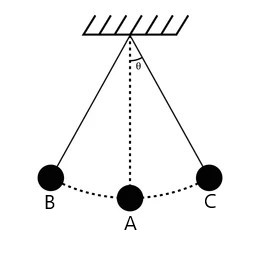

## Solve ODE

The motion of a simple pendulum can be described by a second-order differential equation, but, we need to convert this into a system of first-order equations to solve it numerically.

The second-order differential equation for the angle 
$\theta$ of the pendulum (with respect to the vertical) is given by $\ddot{\theta} + \frac{g}{L} \sin(\theta) = 0
$ 

Here $\ddot{\theta}$ represents the second derivative of theta with respect to time (angular acceleration). Where where $g$ is the acceleration due to gravity, and $L$ is the length of the pendulum. This equation arises from the balance of gravitational and rotational forces acting on the pendulum.

To convert this into a system of first-order differential equations, we introduce $\omega$ as the angular velocity of the pendulum ($\omega=\dot{\theta}$).

 The system of equations then becomes:

 $\frac{d\theta}{dt} = \omega$ and $\frac{d\omega}{dt} = -\frac{g}{L} \sin(\theta)
$

We can now define a function to represent this system and then use `odeint` to solve it. Here's how you would define the function in Python:

### Import Modules

In [ ]:
import numpy as np
from scipy.integrate import odeint
import plotly.graph_objects as go

<div class="alert alert-info">

Note

The functions `create_line_trace`, `create_point_trace`, `create_arrow_trace`, and and others were written in previous tutorials. Please include them in your notebook on top before starting to follow this tutorial. You can download it by clicking the Download icon on the Navigation Bar.

</div>

In [ ]:
def create_line_trace(start, end, color='blue', width=2, name='', dash='solid', showlegend=False):
    line_trace = go.Scatter3d(
        x=[start[0], end[0]],
        y=[start[1], end[1]],
        z=[start[2], end[2]],
        mode='lines',
        line=dict(color=color, width=width, dash=dash),
        name=name,
        showlegend=showlegend
    )
    return line_trace

def create_point_trace(point, color='red', size=5, name=''):
    x, y, z = point
    trace = go.Scatter3d(
        x=[x], y=[y], z=[z],
        mode='markers+text',
        marker=dict(color=color, size=size),
        text=[name],
        textposition="top center",
        showlegend=False
    )
    return trace

def create_arrow_trace(start, end, color='blue', name='', showlegend=False):
    # Create arrow shaft trace
    shaft_trace = go.Scatter3d(
        x=[start[0], end[0]], y=[start[1], end[1]], z=[start[2], end[2]],
        mode='lines',
        line=dict(color=color, width=5),
        name=name,
        showlegend=showlegend
    )

    # Create arrowhead trace
    vec = np.array(end) - np.array(start)
    length = np.linalg.norm(vec)
    vec_normalized = vec / length if length > 0 else vec
    arrowhead_size = 0.1 * length

    head_trace = go.Cone(
        x=[end[0]], y=[end[1]], z=[end[2]],
        u=[vec_normalized[0]], v=[vec_normalized[1]], w=[vec_normalized[2]],
        sizemode="absolute", sizeref=arrowhead_size, showscale=False,
        anchor="tip", colorscale=[[0, color], [1, color]]
    )

    return [shaft_trace, head_trace]

def create_3d_layout(title='3D Plot', gridcolor='lightblue', xaxis_title='X Axis', yaxis_title='Y Axis', zaxis_title='Z Axis'):
    layout = go.Layout(
        title=title,
        scene=dict(
            xaxis=dict(showbackground=False, showgrid=True, zeroline=True, zerolinewidth=2, zerolinecolor='rgba(0,0,0,0.5)', showticklabels=True, gridcolor=gridcolor, title=xaxis_title),
            yaxis=dict(showbackground=False, showgrid=True, zeroline=True, zerolinewidth=2, zerolinecolor='rgba(0,0,0,0.5)', showticklabels=True, gridcolor=gridcolor, title=yaxis_title),
            zaxis=dict(showbackground=False, showgrid=True, zeroline=True, zerolinewidth=2, zerolinecolor='rgba(0,0,0,0.5)', showticklabels=True, gridcolor=gridcolor, title=zaxis_title),
        ),
        scene_aspectmode='cube'
    )
    return layout

def create_orthonormal_frame_traces(frame_name='e', origin=[0, 0, 0], length=1, color='blue', rotation_matrix=np.identity(3)):
    # Define standard basis vectors
    i = np.array([1, 0, 0])
    j = np.array([0, 1, 0])
    k = np.array([0, 0, 1])

    # Apply rotation
    i_rot = np.dot(rotation_matrix, i)
    j_rot = np.dot(rotation_matrix, j)
    k_rot = np.dot(rotation_matrix, k)

    # Create traces for rotated axes with arrows
    frame_traces = []
    frame_traces.extend(create_arrow_trace(start=origin, end=np.array(origin) + length * i_rot, color=color, name=f'{frame_name}_x'))
    frame_traces.extend(create_arrow_trace(start=origin, end=np.array(origin) + length * j_rot, color=color, name=f'{frame_name}_y'))
    frame_traces.extend(create_arrow_trace(start=origin, end=np.array(origin) + length * k_rot, color=color, name=f'{frame_name}_z'))

    return frame_traces

def animate_particle(curve_points, particle_name='Particle', particle_color='red', particle_size=6, animation_speed=10):
    # Creating frames for animation
    frames = []
    for i in range(0, len(curve_points), animation_speed):
        frame = go.Frame(data=[go.Scatter3d(
            x=[curve_points[i][0]],
            y=[curve_points[i][1]],
            z=[curve_points[i][2]],
            mode='markers+text',
            marker=dict(color=particle_color, size=particle_size),
            text=[particle_name],
            textposition='top center',
            textfont=dict(size=15)
        )])
        frames.append(frame)

    return frames

def create_particle_animation(curve_points, title='Particle Animation', name='P', origin=[0, 0, 0]):

    # Validate curve_points
    if not isinstance(curve_points, np.ndarray):
        raise ValueError("curve_points must be a NumPy array.")
    if curve_points.size == 0 or curve_points.ndim != 2 or curve_points.shape[1] != 3:
        raise ValueError("curve_points must be a non-empty 2D NumPy array with 3 columns (x, y, z coordinates).")

    traces = []
    frames = []

    x_vals, y_vals, z_vals = zip(*curve_points)

    # Add initial point and origin 'O'
    traces.append(create_point_trace(curve_points[0], color='green', size=8, name=name))
    traces.append(create_point_trace(origin, color='black', size=3, name='O'))

    # Set layout for the figure
    layout = create_3d_layout(title=title, xaxis_title='X Axis', yaxis_title='Y Axis', zaxis_title='Z Axis')

    # Add path trace
    traces.append(go.Scatter3d(
        x=x_vals, y=y_vals, z=z_vals,
        mode="lines",
        line=dict(color="blue", width=2),
        name='Path'
    ))

    # Animate the particle
    frames = animate_particle(curve_points, name, particle_color='green', particle_size=8, animation_speed=1)

    fig = go.Figure(data=traces, layout=layout, frames=frames)

    # Adjust the camera settings
    fig.update_layout(
        scene=dict(
            camera=dict(
                up=dict(x=0, y=0, z=1),  # Sets the up direction (in this case, the z-axis is up)
                center=dict(x=0, y=0, z=0),  # Centers the view on the given coordinates
                eye=dict(x=1, y=-1.25, z=1.25)  # Sets the position of the camera
            ),
            aspectmode='cube'  # Keeps the aspect ratio of the axes fixed
        )
    )

    # Add play and pause buttons
    fig.update_layout(
        updatemenus=[
            dict(
                type="buttons",
                buttons=[
                    dict(label="Play",
                          method="animate",
                          args=[None, dict(frame=dict(duration=50, redraw=True), fromcurrent=True)]),
                    dict(label="Pause",
                          method="animate",
                          args=[[None], dict(frame=dict(duration=0, redraw=False), mode="immediate")])
                ]
            )
        ]
    )

    return fig

### Define System Function

In [ ]:
def simple_pendulum(y, t, g, L):
    theta, omega = y
    dtheta_dt = omega
    domega_dt = -(g / L) * np.sin(theta)
    return [dtheta_dt, domega_dt]

### Constants and Conditions

In [ ]:
# Constants
g = 9.81  # Acceleration due to gravity (m/s^2)
L = 1.0   # Length of the pendulum (m)
m = 5 # mass

# Initial conditions
theta0 = np.pi / 4  # Initial angle (45 degrees)
omega0 = 0.0        # Initial angular velocity
y0 = [theta0, omega0]

# Time points
t = np.linspace(0, 10, 500)

### Solve ODE

In [ ]:
# Solve ODE
solution = odeint(simple_pendulum, y0, t, args=(g, L))

# Extract the solutions
theta_vals, omega_vals = solution.T

# Compute angular acceleration
alpha_vals = -(g / L) * np.sin(theta_vals)

### Plot the Solutions

In [ ]:
# Create traces
trace1 = go.Scatter(x=t, y=theta_vals, mode='lines', name='Angular Displacement')
trace2 = go.Scatter(x=t, y=omega_vals, mode='lines', name='Angular Velocity')
trace3 = go.Scatter(x=t, y=alpha_vals, mode='lines', name='Angular Acceleration')

# Create a figure
fig = go.Figure()

# Add traces to the figure
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.add_trace(trace3)

# Update layout for a better visualization
fig.update_layout(title='Simple pendulum Dynamics',
                  xaxis_title='Time (s)',
                  yaxis_title='Theta / Omega',
                  legend_title='Variable')

fig.show()

### Animation

In [ ]:
# Convert angular displacement to Cartesian coordinates for animation
x_vals = L * np.sin(theta_vals)
y_vals = -L * np.cos(theta_vals)

# Create the animation
curve_points = np.column_stack((x_vals, y_vals, np.zeros_like(x_vals)))
fig = create_particle_animation(curve_points, title="Simple Pendulum Animation")

# Show the animation
fig.show()

### Energy

Kinetic Energy is given by $E_k = \frac{1}{2}mL^2\omega^2
$ and Potential Energy is given by $E_p = mgh
$ where $h = L - L\cos(\theta)$

In [ ]:
def kinetic_energy(omega, L):
    return 0.5 * m * L**2 * omega**2

def potential_energy(theta, g, L):
    return m * g * L * (1 - np.cos(theta))

# Calculate energies
KE = kinetic_energy(omega_vals, L)
PE = potential_energy(theta_vals, g, L)
TE = KE + PE  # Total Energy

# Plotting energies
energy_fig = go.Figure()
energy_fig.add_trace(go.Scatter(x=t, y=KE, mode='lines', name='Kinetic Energy'))
energy_fig.add_trace(go.Scatter(x=t, y=PE, mode='lines', name='Potential Energy'))
energy_fig.add_trace(go.Scatter(x=t, y=TE, mode='lines', name='Total Energy'))

energy_fig.update_layout(title='Energy of the Mass-Spring System',
                         xaxis_title='Time (s)',
                         yaxis_title='Energy',
                         legend_title='Type of Energy')

energy_fig.show()

### Linear Momentum

In [ ]:
P = m * L * omega_vals
fig = go.Figure()
fig.add_trace(go.Scatter(x=t, y=P, mode='lines',name='Linear Momentum'))
fig.update_layout(title='Linear Momentum Vs Time')
fig.show()